<H1> Objective: To predict the name of pizza brand from the nutritional information </H1>

Source for dataset: Kaggle: https://www.kaggle.com/sdhilip/nutrient-analysis-of-pizzas
- Input: Nutriental facts of the pizza
- Ouput (to be predicted): Brand of pizza

This is a multi-class classification problem

In [1]:
### Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

In [2]:
### Read the csv file into pandas dataframe
df = pd.read_csv("pizza.csv")

In [3]:
#Overview of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 9 columns):
brand     300 non-null object
id        300 non-null int64
mois      300 non-null float64
prot      300 non-null float64
fat       300 non-null float64
ash       300 non-null float64
sodium    300 non-null float64
carb      300 non-null float64
cal       300 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 21.2+ KB


- There are 9 columns and 300 observations
- No missing or null data in any column
- All columns are of type float except brand and id which are types object and int respectively.

In [3]:
## Checking for duplicated observations in the dataset
print("No of duplicated observations:", df.duplicated(keep = 'last').sum())
tidy_df = df.drop(df[df.duplicated(keep = 'last')].index, axis = 0)

No of duplicated observations: 5


5 duplicated observations were found and were removed from the dataframe

In [5]:
## Univariate analysis of "brand"
print("Number of unique brands", tidy_df.brand.nunique())
print("Number of observations per brand:", tidy_df.brand.value_counts())
tidy_df.head()

Number of unique brands 10
Number of observations per brand: D    32
H    32
B    31
J    30
F    30
I    29
A    29
G    29
C    27
E    26
Name: brand, dtype: int64


,brand,id,mois,prot,fat,ash,sodium,carb,cal
0,A,14069,27.82,21.43,44.87,5.11,1.77,0.77,4.93
1,A,14053,28.49,21.26,43.89,5.34,1.79,1.02,4.84
2,A,14025,28.35,19.99,45.78,5.08,1.63,0.80,4.95
3,A,14016,30.55,20.15,43.13,4.79,1.61,1.38,4.74
4,A,14005,30.49,21.28,41.65,4.82,1.64,1.76,4.67


There are 10 brands of pizzas found and the number of observations is similar that it can be considered as a balanced dataset.

Total number of classes: 10

In [42]:
## What is id and what does it say?
## Univariate analysis of "id"
print("Number of unique id", tidy_df.id.nunique())
id_val = tidy_df.id.value_counts()
print("Repeated ID's and their counts:\n",id_val[id_val > 1])
## What does the id represent? Are there same ids for 2 different brands?
tidy_df[tidy_df.id.duplicated(keep = False)].sort_values(by = 'id')

Number of unique id 291
Repeated ID's and their counts:
 14029    2
24035    2
24043    2
24049    2
Name: id, dtype: int64


,brand,id,mois,prot,fat,ash,sodium,carb,cal
65,C,14029,49.73,25.65,19.98,2.51,0.52,2.13,2.91
124,E,14029,39.59,8.36,4.39,1.52,0.48,46.14,2.58
137,E,24035,34.31,7.98,14.54,1.46,0.49,41.71,3.30
161,F,24035,27.65,7.78,17.30,1.29,0.40,46.25,3.72
77,C,24043,52.19,26.00,16.64,4.17,0.61,1.00,2.58
118,D,24043,52.19,26.00,16.64,4.17,0.61,1.00,2.58
52,B,24049,50.87,13.85,27.64,3.71,1.10,3.93,3.20
162,F,24049,28.33,7.82,17.96,1.41,0.45,44.48,3.71


- ID is the sample analyzed
- ID is not a unique identifier of every sample. There are 291 unique IDs. 2 brands can have the same sample IDs. 
- There are 4 same ids in the dataset that is found for 2 brands.  Except for id '24043', all the ids have different values for different brands. Why does 24043 have exactly the same values for all the columns?

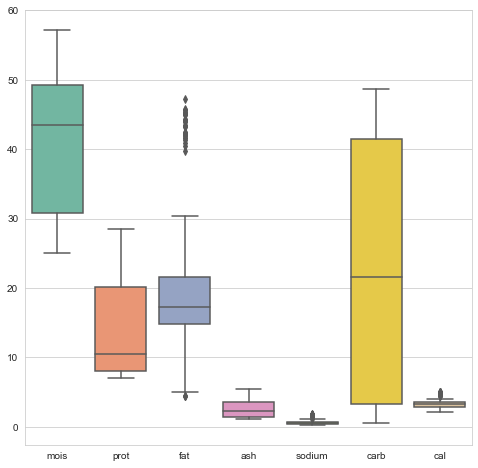

In [43]:
#Visualization of descriptive statistical summary of numerical features
sns.boxplot(data=tidy_df.iloc[:,2:], palette="Set2")

Box plot of the features in the dataframe (excluding brands and unique ID). 
This gives the range, median and outlier (based on LL-1.5IQR and UP +1.5IQR) 
Note that all these nutrients are the amount per 100g in the sample
Observations:
    1. The range of sodium and calories in the dataset is very small. Though the units of all these variables are amount per 100g of sample, the scale is different and thus it would be best to standardize the features (especially since KNN with Euclidean distance will be used for classification)
    2. Outliers are present for fat indicating that some samples or brands have high fat compared to others
    3. From the median of mois and prot, it is clear that they are skewed/asymmetrical data 

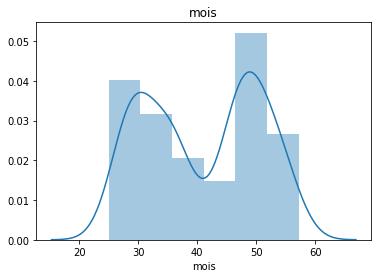

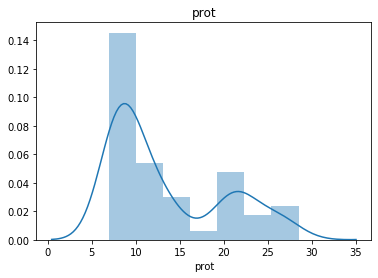

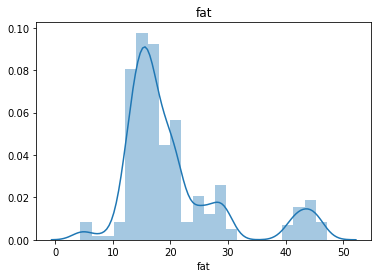

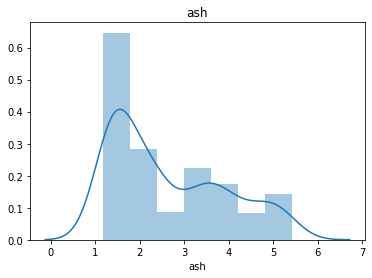

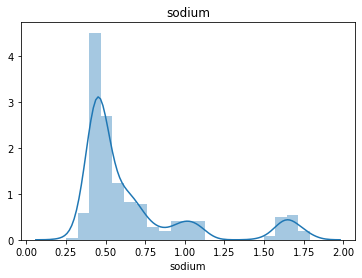

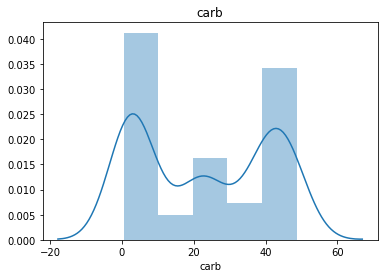

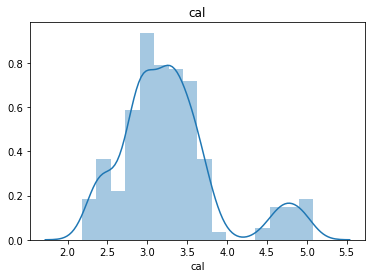

In [10]:
### Viewing Histogram and distribution of the data
for i in tidy_df.columns[2:]:
    plt.figure()
    sns.distplot(df[i])
    plt.title(i)

None of the features exhibit normal distribution. They all are bimodal or trimodal or more

/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 1296x1296 with 0 Axes>

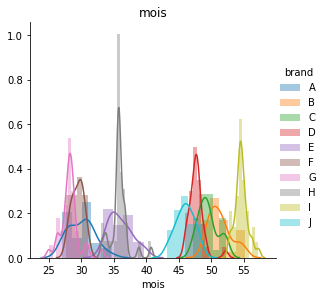

<Figure size 1296x1296 with 0 Axes>

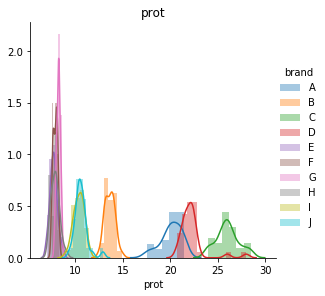

<Figure size 1296x1296 with 0 Axes>

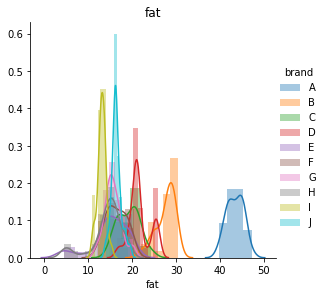

<Figure size 1296x1296 with 0 Axes>

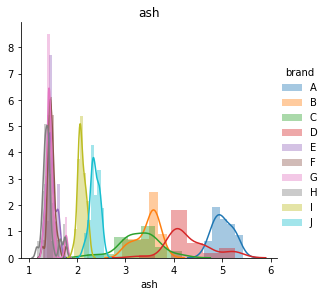

<Figure size 1296x1296 with 0 Axes>

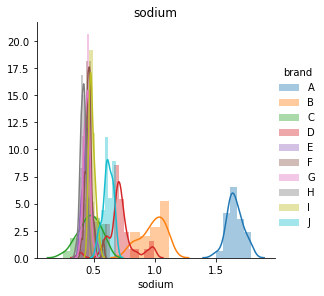

<Figure size 1296x1296 with 0 Axes>

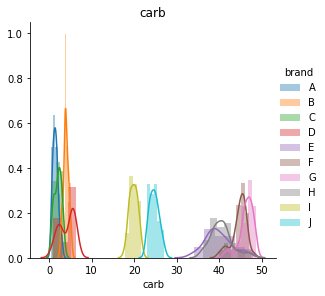

<Figure size 1296x1296 with 0 Axes>

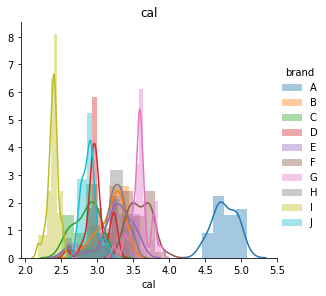

In [11]:
## Visualizing frequency and pdf facted by the brand to understand features
from matplotlib import rcParams
rcParams['figure.figsize'] = 18,18
for i in tidy_df.columns[2:]:
    plt.figure()
    sns.FacetGrid(tidy_df, hue="brand", size=4) \
       .map(sns.distplot, i) \
       .add_legend();
    plt.title(i)
    plt.show()

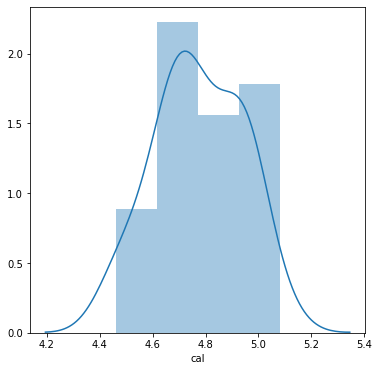

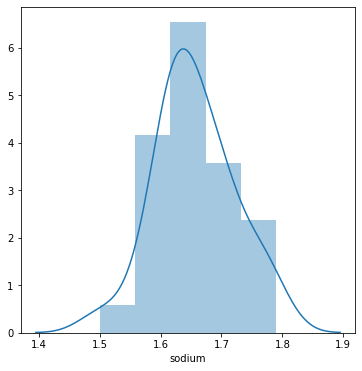

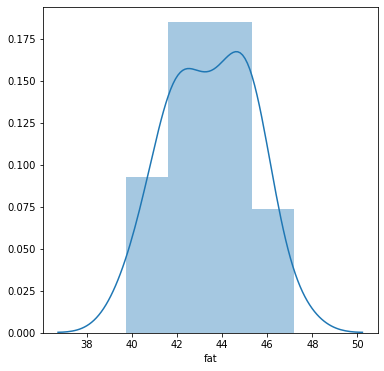

In [12]:
A = tidy_df[tidy_df.brand == "A"]
rcParams['figure.figsize'] = 6,6
sns.distplot(A.cal)
plt.show()
sns.distplot(A.sodium)
plt.show()
sns.distplot(A.fat)
plt.show()


Overlapping the PDF of brand's features indicates that Brand A can be easily classified with just one feature: Either 
    - fat (value: >37) and/or
    - sodium (value: >1.4) and/or
    - cal (value: >4.2)

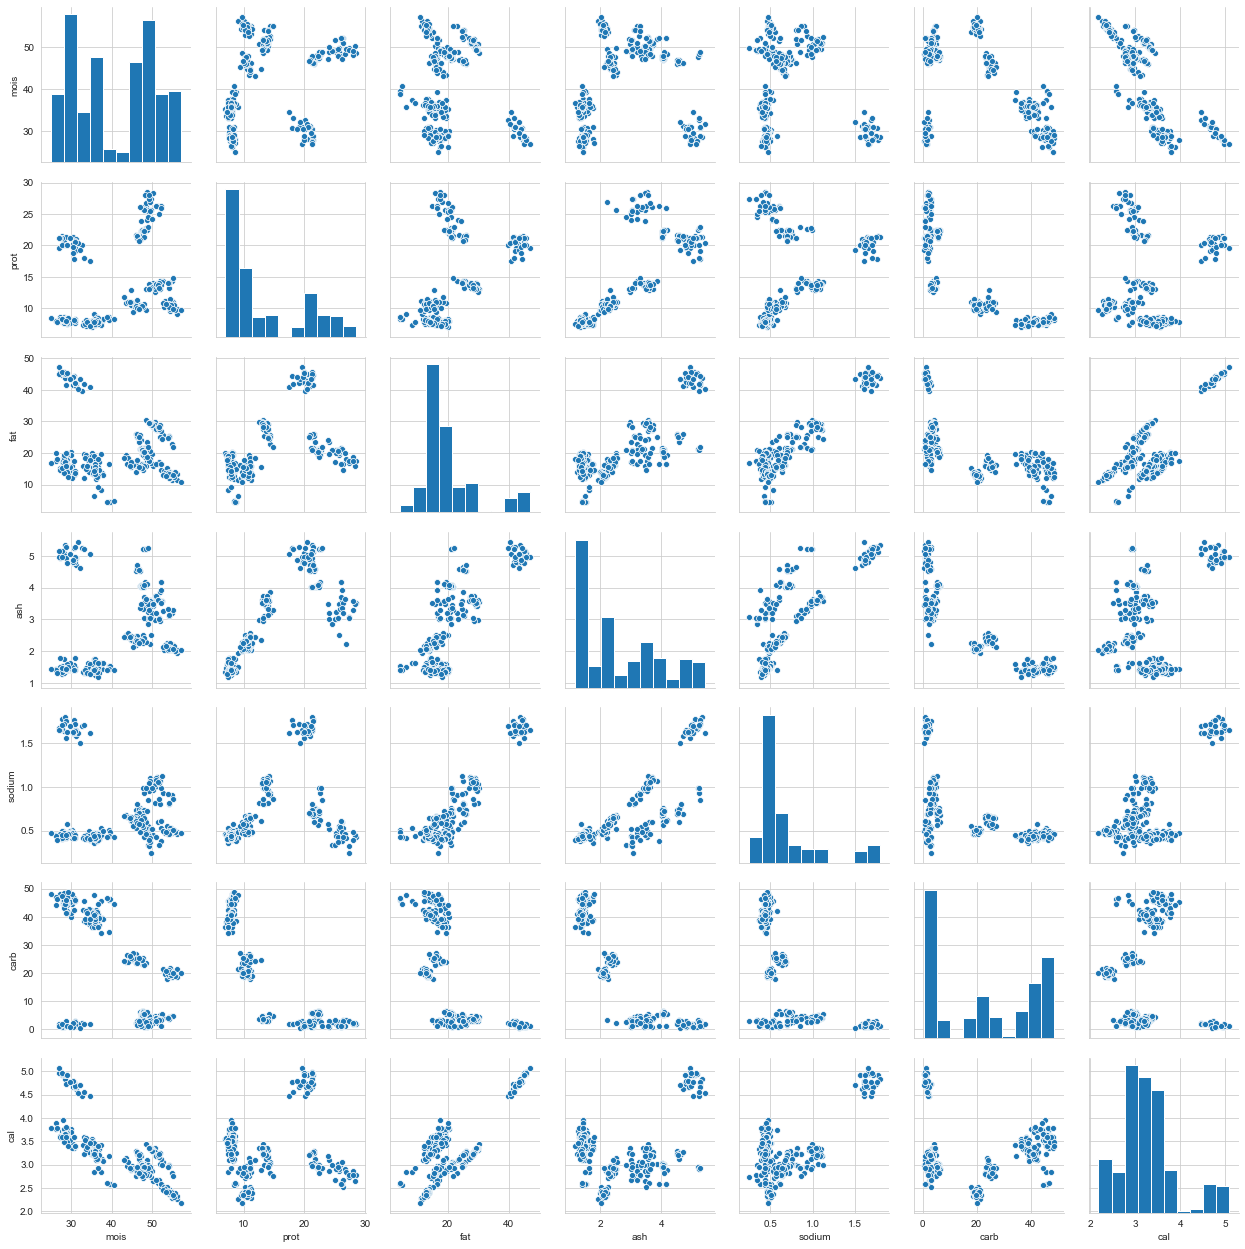

In [45]:
## Bivariate analysis
sns.pairplot(tidy_df.iloc[:,2:])
plt.show()

From the pairplot, it is clear that the data is clustered and the nature of relationship between 2 variables can vary from one cluster to other. In general,
- moisture is inversely related to fat and calories --> More moisture healthier pizza
- fat and calories are directly related
- ash and sodium are directly related


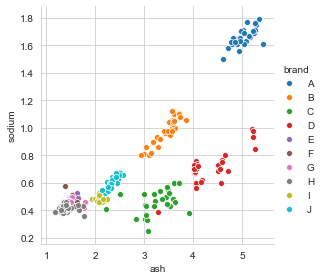

In [14]:
# More evidence to the observation made above
rcParams['figure.figsize'] = 8,8
sns.set_style("whitegrid");
sns.FacetGrid(tidy_df, hue="brand", size=4) \
    .map(sns.scatterplot, "ash", "sodium") \
    .add_legend();
plt.show()    

In [59]:
### Performing T-SNE to visualize the data in 2 dimensions
## 1. Feature Standardization
scale = StandardScaler()
standard_data = scale.fit_transform(tidy_df.iloc[:,2:])
np.cov(standard_data.T)

array([[ 1.00340136,  0.36262606, -0.1725441 ,  0.2656928 , -0.10421277,
        -0.59439922, -0.76731828],
       [ 0.36262606,  1.00340136,  0.49725883,  0.82533664,  0.42743681,
        -0.85591659,  0.0680474 ],
       [-0.1725441 ,  0.49725883,  1.00340136,  0.79425032,  0.93704677,
        -0.64136003,  0.76730768],
       [ 0.2656928 ,  0.82533664,  0.79425032,  1.00340136,  0.81017658,
        -0.90141742,  0.32783392],
       [-0.10421277,  0.42743681,  0.93704677,  0.81017658,  1.00340136,
        -0.62074604,  0.67542646],
       [-0.59439922, -0.85591659, -0.64136003, -0.90141742, -0.62074604,
         1.00340136, -0.02238478],
       [-0.76731828,  0.0680474 ,  0.76730768,  0.32783392,  0.67542646,
        -0.02238478,  1.00340136]])

In [61]:
### Dimensionality Reduction via Principal component analysis
pca = PCA().fit(standard_data)
pca.explained_variance_

array([4.18169196e+00, 2.30189812e+00, 4.16929044e-01, 9.51450495e-02,
       2.77954990e-02, 3.40233641e-04, 9.61746718e-06])

Text(0, 0.5, 'Percentage variance explained')

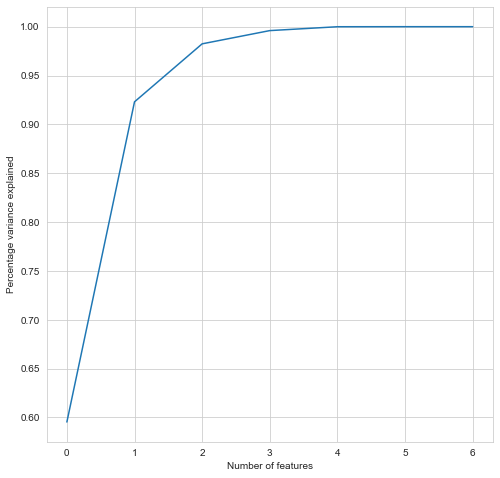

In [62]:
## Determine the optimal number of compoents for PCA
percentage_var_expl = pca.explained_variance_/np.sum(pca.explained_variance_)
cum_per_var = np.cumsum(percentage_var_expl)
plt.plot(cum_per_var)
plt.xlabel("Number of features")
plt.ylabel("Percentage variance explained")

Out of 7 possible principal components, first 4 of them explains 100% of the variance in the data with 3 components explaining more than 95% of the data's variance. So, number of components in PCA can be fixed to 4

In [63]:
## 4 PCA components will be used for classification
pca = PCA(n_components = 4)
pca_data = pca.fit_transform(standard_data)
pca_df = pd.DataFrame(data = pca_data, columns = ["1st PCA Component", "2nd PCA Component", "3rd PCA Component", "4th PCA Component"])

1st and 2nd
1st and 3rd
1st and 4th
2nd and 3rd
2nd and 4th
3rd and 4th


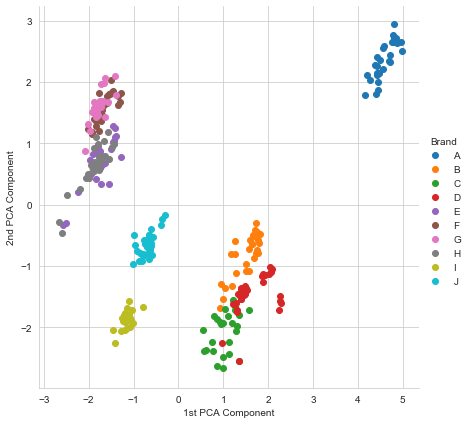

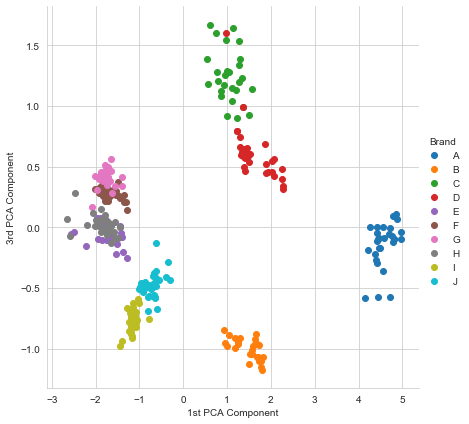

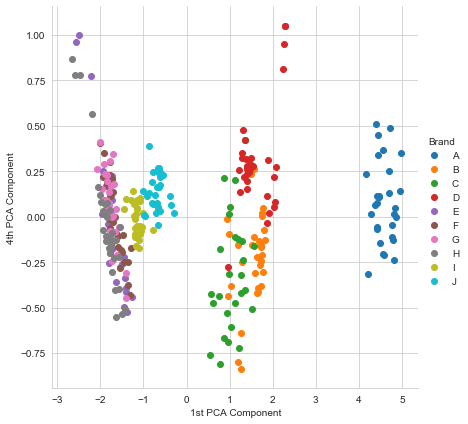

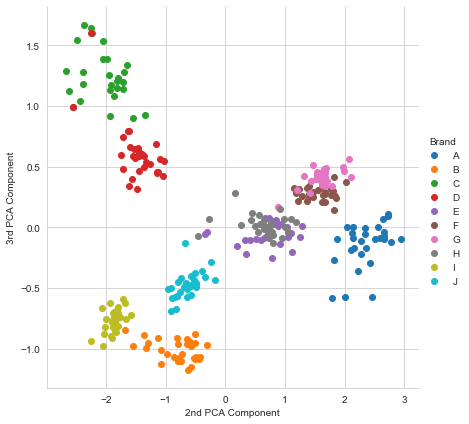

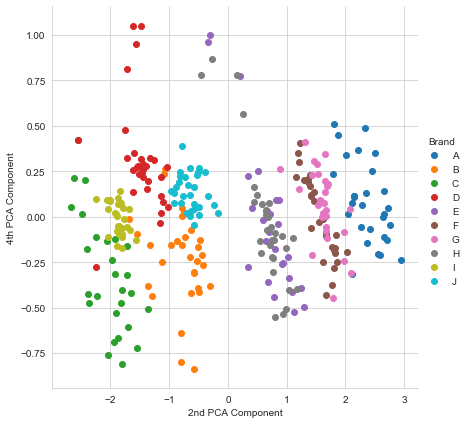

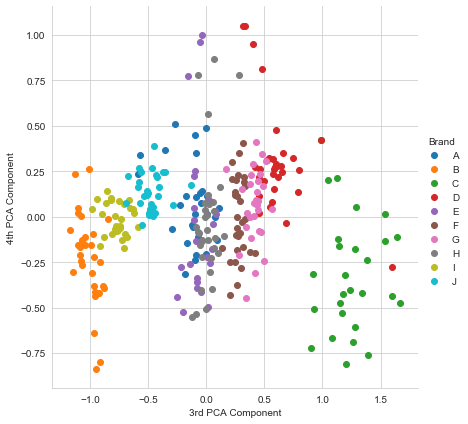

In [64]:
#Visualizing the dataset after dimensionality reduction
pca_df['Brand'] = pd.Series(tidy_df['brand']).reset_index(drop = True)
print("1st and 2nd")
sns.FacetGrid(pca_df, hue="Brand", height=6).map(plt.scatter,"1st PCA Component", "2nd PCA Component").add_legend()
print("1st and 3rd")
sns.FacetGrid(pca_df, hue="Brand", height=6).map(plt.scatter,"1st PCA Component", "3rd PCA Component").add_legend()
print("1st and 4th")
sns.FacetGrid(pca_df, hue="Brand", height=6).map(plt.scatter,"1st PCA Component", "4th PCA Component").add_legend()
print("2nd and 3rd")
sns.FacetGrid(pca_df, hue="Brand", height=6).map(plt.scatter,"2nd PCA Component", "3rd PCA Component").add_legend()
print("2nd and 4th")
sns.FacetGrid(pca_df, hue="Brand", height=6).map(plt.scatter,"2nd PCA Component", "4th PCA Component").add_legend()
print("3rd and 4th")
sns.FacetGrid(pca_df, hue="Brand", height=6).map(plt.scatter,"3rd PCA Component", "4th PCA Component").add_legend()



#"1st PCA Compoenent", "2nd PCA Component", "3rd PCA Component", "4th PCA Component"

PCA distinguished 6 clusters or brands (A, B, C, D, I and J) correctly. It was not able to disntguish the rest of the four brands. This can be attributed to the possible non-linear correlation between the features of these brands as PCA is limited to linear transformation. 

In [90]:
### Classification of pizzas

### Splitting dataset into train and test
X = pca_df.iloc[:,:-1]
y = pca_df.iloc[:,-1]
# Spliting the dataset to perform cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## To perform 10-fold cross validation
train_accuracy = []
test_accuracy = []
k = [i for i in range(1,100) if i%2 !=0 ]
for i in k:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    train_accuracy.append(cross_val_score(knn, X_train, y_train, cv=10).mean())
    test_accuracy.append(knn.score(X_test, y_test))
    
train_error = [1-i for i in train_accuracy] #1-accuracy = error
test_error = [1-i for i in test_accuracy]

Text(0.5, 1.0, 'Train/test error vs K to find the optimal K')

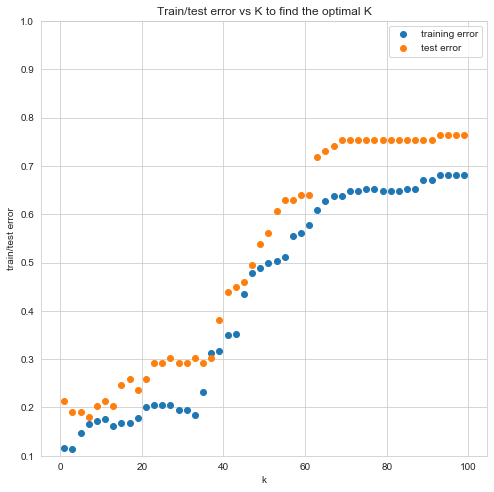

In [91]:
plt.scatter(k, train_error, label = "training error")
plt.scatter(k, test_error, label = "test error")
plt.xlabel("k")
plt.ylabel("train/test error")
plt.ylim(0.1, 1)
plt.legend()
plt.title("Train/test error vs K to find the optimal K")

- K = 1 indicates low training error and relatively high test error. At K =1, the model is overfitting the training data. 

- As k increases, the training error increases, while there is a drop in test error. This drop or lowest value in the region indicates good balance between overfitting and underfitting. 

- As k gets >~20, the test error is constant and it is not fitting the data -- underfitting 

- K = 7 is the optimal K

In [92]:
optimal_k = k[test_error.index(min(test_error))]
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k) ## 10 class classification. How is k =7 good enough
knn_optimal.fit(X_train, y_train)
print("Score (Mean accuracy): {:.4f}".format(knn_optimal.score(X_test, y_test)))
print("Precision: ", precision_score(y_test, knn_optimal.predict(X_test), average = None))
print("Confusion Matrix: ", confusion_matrix(y_test, knn_optimal.predict(X_test)))

Score (Mean accuracy): 0.8202
Precision:  [1.         1.         0.875      1.         0.29411765 0.875
 0.6        1.         1.         1.        ]
Confusion Matrix:  [[ 9  0  0  0  0  0  0  0  0  0]
 [ 0  7  0  0  0  0  0  0  0  0]
 [ 0  0  7  0  0  0  0  0  0  0]
 [ 0  0  1 10  0  0  0  0  0  0]
 [ 0  0  0  0  5  0  0  0  0  0]
 [ 0  0  0  0  0  7  2  0  0  0]
 [ 0  0  0  0  0  1  3  0  0  0]
 [ 0  0  0  0 12  0  0  5  0  0]
 [ 0  0  0  0  0  0  0  0  9  0]
 [ 0  0  0  0  0  0  0  0  0 11]]


- The accuracy of the model is 82%
- Precision is ratio of true positive to the sum of true postive and false postive and it gives the percentage of correctly classified positive labels among all the positively predicted labels. Precision for all brands are 1 (correctly classification) except for Brand C, D, E and F. Brand E has the lowest precision - only ~30% of the datasets are classified correctly. 
- Looking at confusion matrix for brand E, it is clear that the model has classified ~70% of the Brand E's data as brand H

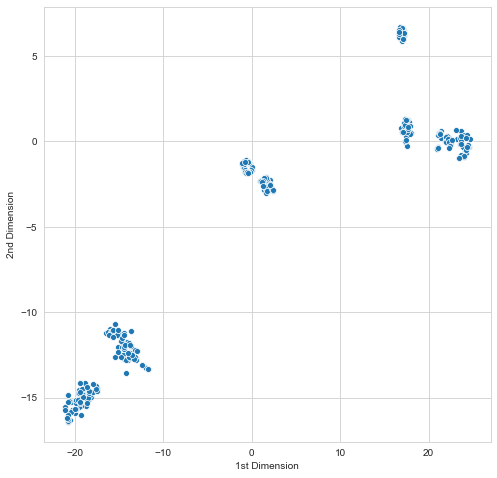

In [60]:
##Using TSNE to visualize the data
#TSNE(n_components = 2)
TSNE_data = TSNE(n_components=2, perplexity = 50, n_iter = 9000).fit_transform(standard_data)
TSNE_df = pd.DataFrame(data = TSNE_data, columns = ["1st Dimension", "2nd Dimension"])
sns.scatterplot(x="1st Dimension", y="2nd Dimension", data=TSNE_df)